In [2]:
import cffi
import numpy as np


_ffi = cffi.FFI()
_ffi.cdef('void pyconcaveman2d(double *points_c, size_t num_points, int *hull_points_c, size_t num_hull_points, double concavity, double lengthThreshold, double **p_concave_points_c, size_t *p_num_concave_points, void (**p_free)(void*));')
_lib = _ffi.dlopen('/home/raja/dev/p/comp-geo/alphashape/libconcaveman.so')


def concaveman2d(points, hull, concavity=2.0, lengthThreshold=0.0):
    points = np.array(points).astype(np.double)
    hull = np.array(hull).astype(np.int32)

    if len(points.shape) != 2:
        raise ValueError('points must be a 2-D array')

    if len(hull.shape) != 1:
        raise ValueError('hull must be a 1-D array')

    if np.any(hull >= len(points)) or np.any(hull < 0):
        raise ValueError('hull indices out of bounds')

    p_concave_points_c = _ffi.new('double**')
    p_num_concave_points = _ffi.new('size_t*')
    p_free = _ffi.new('void(**)(void*)')

    points_c = _ffi.cast('double*', points.ctypes.data)
    hull_c = _ffi.cast('int*', hull.ctypes.data)
    _lib.pyconcaveman2d(points_c, len(points),
        hull_c, len(hull),
        concavity, lengthThreshold,
        p_concave_points_c, p_num_concave_points,
        p_free)

    num_concave_points = p_num_concave_points[0]
    concave_points_c = p_concave_points_c[0]

    buffer = _ffi.buffer(concave_points_c, 8 * 2 * num_concave_points)

    concave_points = np.frombuffer(buffer, dtype=np.double)
    concave_points = concave_points.reshape((num_concave_points, 2))
    concave_points = concave_points.copy()

    print('concave_points:', concave_points)

    p_free[0](concave_points_c)

    return concave_points

In [3]:
import csv
with open("best_results.csv") as fp:
    reader = csv.reader(fp)
    best_results = []
    for i, row in enumerate(reader):
        if i == 0:
            continue
        best_results.append(map(float, row))
        
reachable = [(lng, lat) for lat, lng, travel_time in best_results if travel_time <= 180.0 * 60.0]

In [7]:
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull
hull = ConvexHull(reachable)
hull.vertices

array([122660, 125203, 125197, 125187, 118502, 123817, 125312, 125214,
       125321, 125324, 125286, 125279, 125217, 125213, 123108, 122893,
       122124, 122068, 122240, 122260], dtype=int32)

pyconcaveman2d(), concavity: 2 lengthThreshold: 0
points:
-85.8644 38.2816
-85.8699 38.2837
-85.8087 38.2953
-85.8084 38.2949
-85.8191 38.3436
-85.8191 38.3438
-85.8144 38.3405
-85.814 38.3399
-85.8207 38.3404
-85.8208 38.3404
-85.8142 38.2863
-85.8137 38.2865
-85.8172 38.3004
-85.8183 38.3023
-85.8122 38.2988
-85.8125 38.2989
-85.8205 38.3415
-85.8205 38.3416
-85.8005 38.3038
-85.799 38.3034
-85.8063 38.3124
-85.8061 38.3127
-85.8429 38.3428
-85.8397 38.3415
-85.8091 38.2869
-85.8079 38.2871
-85.7941 38.3509
-85.794 38.3511
-85.817 38.3068
-85.817 38.3086
-85.7921 38.3639
-85.7909 38.3642
-85.8253 38.2905
-85.8253 38.2905
-85.7947 38.35
-85.7947 38.35
-85.7952 38.3502
-85.7949 38.35
-85.8048 38.2916
-85.8048 38.2917
-85.817 38.2905
-85.8175 38.2914
-85.8189 38.2847
-85.8185 38.2841
-85.7882 38.3018
-85.7882 38.302
-85.7919 38.3537
-85.7916 38.3534
-85.8386 38.296
-85.8387 38.2965
-85.7939 38.3529
-85.7942 38.3526
-85.7927 38.3231
-85.7933 38.3236
-85.8027 38.2894
-85.8033 38.29
-85.81

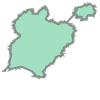

In [8]:
Polygon(concaveman2d(reachable, hull.vertices))